# Raytracing Demo

In this notebook, we will see a minimal working example of FlowPM to run the Nbody and generate a Weak Lensing Mock Map



In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import a_of_chi, rad_comoving_distance
import flowpm.raytracing as raytracing
from flowpm.cosmology import Planck15
import flowpm.constants as constants
import flowpm  
import flowpm.scipy.interpolate as interpolate
from itertools import cycle
from flowpm.fourier_smoothing import fourier_smoothing
import astropy.units as u
from flowpm.tfpm import make_ode_fn
import tensorflow_probability as tfp
import cmasher as cmr
import matplotlib.colors as colors


Populating the interactive namespace from numpy and matplotlib


### Define key parameters of our Universe

In [2]:
nc=[128,128,128]   #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
Boxsize=[205,205,205] #Physical size of the Universe in Mpc/h
n_lens= 11

In [3]:
Omega_c= 0.2589
Omega_b=0.04860
sigma8= 0.8159
n_s= 0.9667
h= 0.6774
w0= -1.0

In [4]:
cosmology = flowpm.cosmology.Planck15()
r = tf.linspace(0., Boxsize[0] * n_lens, n_lens + 1)
a =flowpm.tfbackground.a_of_chi(cosmology, r)
r_center = 0.5 * (r[1:] + r[:-1])
a_center = flowpm.tfbackground.a_of_chi(cosmology, r_center)
stages = a_center[::-1]
batch_size=1   #Batch size, how many independent Universes to simulate

2022-07-28 12:16:33.417285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 12:16:34.658817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38427 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2022-07-28 12:16:34.659501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38427 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-07-28 12:16:34.660148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/devi

Text(0.5, 0, 'Mpc/h')

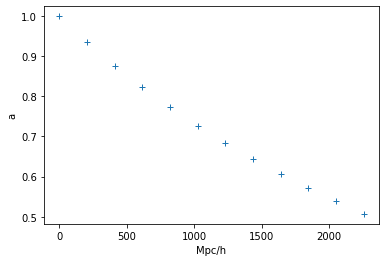

In [5]:
# This allows us to go to roughly z=1
plot(r,a, '+')
ylabel(r'a')
xlabel(r'Mpc/h')

#### Genereting the initial conditions 

In [6]:
a0=0.14285714254594556 #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
k = tf.constant(np.logspace(-4, 1, 128), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(
        tf.reshape(
            interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k,
                                  pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(nc,    
                                            Boxsize, 
                                             pk_fun,         
                                             batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions,
                                    a0)
initial_state = initial_state[0:2]  



#### Running the simulations

In [7]:

res = tfp.math.ode.DormandPrince(rtol=1e-5,
                                     atol=1e-5).solve(make_ode_fn(nc),
                                                      a0,
                                                      initial_state,
                                                      solution_times=stages,
                                                      constants={
                                                          'Omega_c': Omega_c,
                                                          'sigma8': sigma8,
                                                          'Omega_b': Omega_b,
                                                          'n_s': n_s,
                                                          'h': h,
                                                          'w0': w0,
                                                      })


#### Retrieve final density field

In [8]:
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions),res.states[::-1][0][0])[0]

#### And this is what remains of the simulation at redhift 0.034

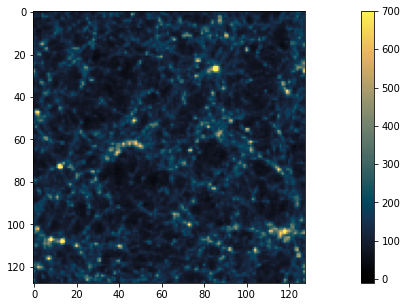

In [9]:

figure(figsize=[20,5])
imshow(final_field.numpy().sum(axis=0),cmap=cmr.eclipse,vmin=-10,vmax=700)
colorbar()

# Genereting the Ray-Traced Weak Lensing Mock Map


In [10]:
field_npix= 1024 
field_size=5.

#### Let's define the source's redshift

In [11]:
z_source=1
a_source=1/(1.0 + z_source)
d_source=rad_comoving_distance(cosmology,a_source)

#### Constructing the lightcone

In [12]:
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(
        res.states[::-1][i],
        nc,
        nc[0] // 2,
        width=nc[0],
        plane_resolution=2048,
        rotation=matrix[j],
        shift=flowpm.raytracing.random_2d_shift(),
    )

    plane = fourier_smoothing(plane, sigma=1.024, resolution=2048)
    lensplanes.append((r_center[i], res.times[::-1][i], plane))
xgrid, ygrid = np.meshgrid(
    np.linspace(0, field_size, field_npix,
                endpoint=False),  # range of X coordinates
    np.linspace(0, field_size, field_npix,
                endpoint=False))  # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)
c = coords.reshape([2, -1]).T / 180. * np.pi  # convert to rad from deg
m = flowpm.raytracing.convergenceBorn(cosmology,
                                      lensplanes,
                                      dx=Boxsize[0] / 2048,
                                      dz=Boxsize[0],
                                      coords=c,
                                      z_source=z_source,
                                      field_npix=field_npix)

2022-07-28 12:17:47.693891: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


#### Here are the lens planes exported during the simulation

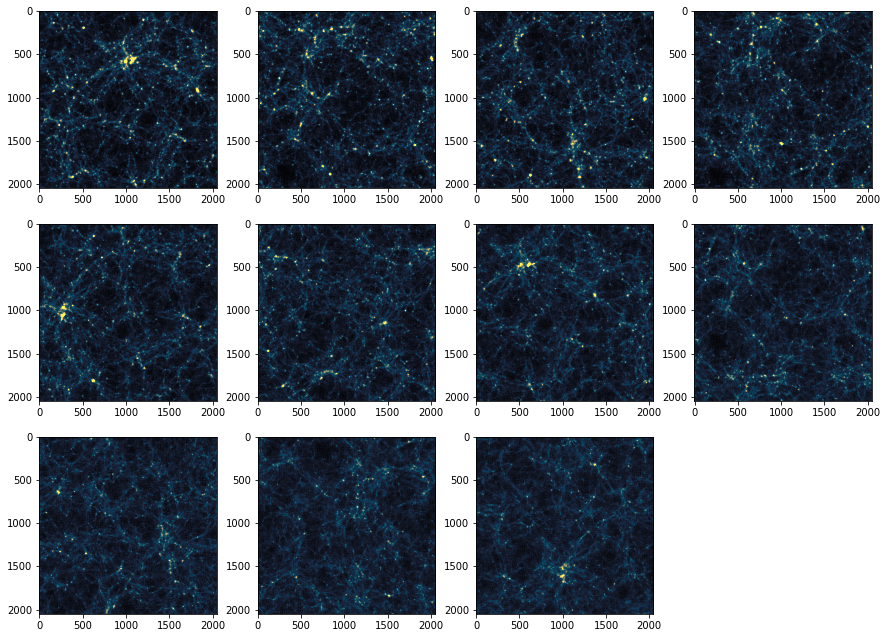

In [13]:

figure(figsize=[15,15])
for i in range(len(lensplanes)):
    subplot(4,4,i+1)
    imshow(lensplanes[i][-1][0],cmap=cmr.eclipse,vmin=0,vmax=6)
    

#### Here the final convergence map

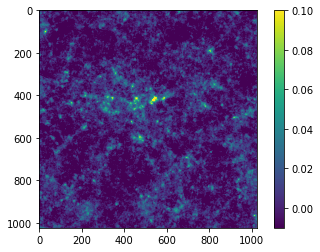

In [14]:
imshow(m[0],cmap='viridis',vmin=-0.01, vmax=0.1); 
colorbar()